# Analisi Rendimento Studenti

All'interno di questo notebook esamineremo dati sociali, di genere e di abitudini relativi ad una classe di studenti di portoghese. Useremo le informazioni estratte per costruire dei modelli che siano in grado di predire il rendimento degli studenti nell'esame finale (G3).

## Indice dei contenuti

* [Operazioni preliminari](#op_prel)
* [Exploratory Data Analysis](#EDA)
    * [Informazioni generali](#info_gen)
    * [Situazione familiare](#situazione_familiare)
    * [Rendimento e assenze](#rendimento_assenze)
    * [Consumo di alcolici e implicazioni](#alcol)
    * [Variabili più rilevanti](#rel_var)
* [Data cleaning](#data_cleaning)
    * [Voto finale uguale a 0](#zero)
    * [Feature Scaling](#fs)
* [Modelli di predizione](#models)
    * [Decision Tree](#dt)
    * [Mean Squared Error](#MSE)
    * [Linear Regression](#lr)
    * [Ridge Regression](#rr)
    * [KNN, Random Forest e Support Vector Machines](#knn)
* [Conclusioni](#conclusioni)

---

## Operazioni preliminari <a id=op_prel></a>

I dati utilizzati per questa analisi sono stati forniti da [kaggle](https://www.kaggle.com/uciml/student-alcohol-consumption?select=student-por.csv). Per analizzare l'impatto dell'alcol e di altri fattori sul rendimento degli studenti, prederemo in considerazione esclusivamente il file .csv contenente le informazioni della classe di portoghese.

Di seguito si provvede a caricare il dataset e importare le librerie utili per l'analisi dei dati e la costruzione dei modelli di predizione.

In [4]:
# mostro i grafici inline
%matplotlib inline

# importo le librerie
from matplotlib import pyplot as plt
from warnings import filterwarnings
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.feature_selection import SelectFromModel

In [2]:
# carico il dataset
df_por = pd.read_csv('data/student-por.csv')

---

## Exploratory Data Analysis <a id = EDA></a> 

Nell'analisi esplorativa dei dati, prenderemo in considerazione diverse caratteristiche degli studenti.

In primo luogo studieremo come varia il rapporto degli studenti con la famiglia e quale sia il contesto in cui crescono, attraverso variabili come il grado di istruzione e il tipo di occupazione dei genitori. Poi sposteremo il focus sul rendimento e l'impatto che il consumo di alcolici ha su di esso. Infine, getteremo uno sguardo d'insieme sulle features, per stabilire quali di queste assumono un peso determinante nella stima del voto finale.  

### Informazioni generali <a id = info_gen></a> 

In [3]:
# ispeziono la struttura 
df_por.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
len(df_por) # numero di studenti

649

In [5]:
df_por.info() # info sulle features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [6]:
df_por.describe() # indicatori per features quantitative

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [7]:
df_por.isna().sum() # non ci sono elementi nulli

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [9]:
# imposto lo stile di seaborn
sns.set_style('dark')

# imposto la gamma dei colori
sns.set_palette('pastel')

In [10]:
# modifico il colore dei bordi dei grafici
plt.rcParams['patch.edgecolor'] = 'black'
plt.rcParams['legend.edgecolor'] = '0.5'
plt.rcParams['axes.edgecolor'] = 'black'

# modifico grandezza delle etichette
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 19

# modifico grandezza dei ticks sugli assi
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

### Situazione familiare <a id = situazione_familiare></a>

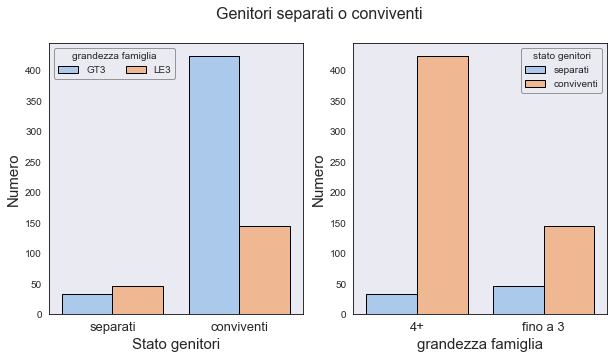

In [12]:
# creo figura ed assi
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

# situazione familiare
sns.countplot(x='Pstatus', hue='famsize', data= df_por, ax = ax[0])
sns.countplot(hue='Pstatus', x='famsize', data= df_por, ax = ax[1])

# titolo figura
fig.suptitle('Genitori separati o conviventi', size = 16)

# titolo asse x
ax[0].set_xlabel('Stato genitori')
ax[1].set_xlabel('grandezza famiglia')

# titolo asse y
ax[0].set_ylabel('Numero')
ax[1].set_ylabel('Numero')

# titoli legende
ax[0].legend(title = 'grandezza famiglia', ncol = 2)
ax[1].legend(labels = ['separati', 'conviventi'], title = 'stato genitori')

# etichette assi
ax[0].set_xticklabels(['separati', 'conviventi'])
ax[1].set_xticklabels(['4+', 'fino a 3'])

plt.show()

Si può notare come gli studenti che hanno genitori conviventi presentino nuclei familiari di dimensioni più grandi e tra i grandi nuclei familiari la percentuale di genitori separati è minore.

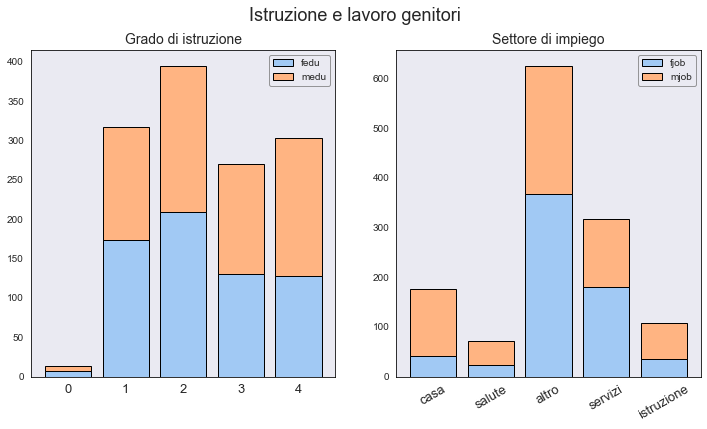

In [15]:
# creo delle serie coi vari gradi di istruzione
medu = df_por.Medu.value_counts().sort_index()
fedu = df_por.Fedu.value_counts().sort_index()

# creo delle serie coi vari settori di impiego
mjob = df_por.Mjob.value_counts().sort_index()
fjob = df_por.Fjob.value_counts().sort_index()

# creo una figura
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

# titolo della figura
fig.suptitle('Istruzione e lavoro genitori', size = 18)

# titolo dei grafici
ax[0].set_title('Grado di istruzione', size = 14)
ax[1].set_title('Settore di impiego', size = 14)

# creo grafico con livelli di istruzione 
ax[0].bar(fedu.index, fedu, label = 'fedu')
ax[0].bar(medu.index, medu, bottom = fedu, label = 'medu')

# creo grafico con settori di impiego
ax[1].bar(fjob.index, fjob, label = 'fjob')
ax[1].bar(mjob.index, mjob, bottom = fjob, label = 'mjob')

# imposto posizione e rinomino etichette
ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels(['casa', 'salute', 'altro', 'servizi', 'istruzione'], rotation = 30)

# aggiungo legende
ax[0].legend()
ax[1].legend()

plt.show()

La quota maggiore dei genitori ha un livello di istruzione compreso tra il 5th e il 9th grade (equivalente circa alle scuole medie). Tuttavia rimangono comunque alte le quote dei genitori che hanno frequentato le scuole superiori o l'università. Piuttosto elevato anche il numero di coloro che vantano solamente un'istruzione primaria.

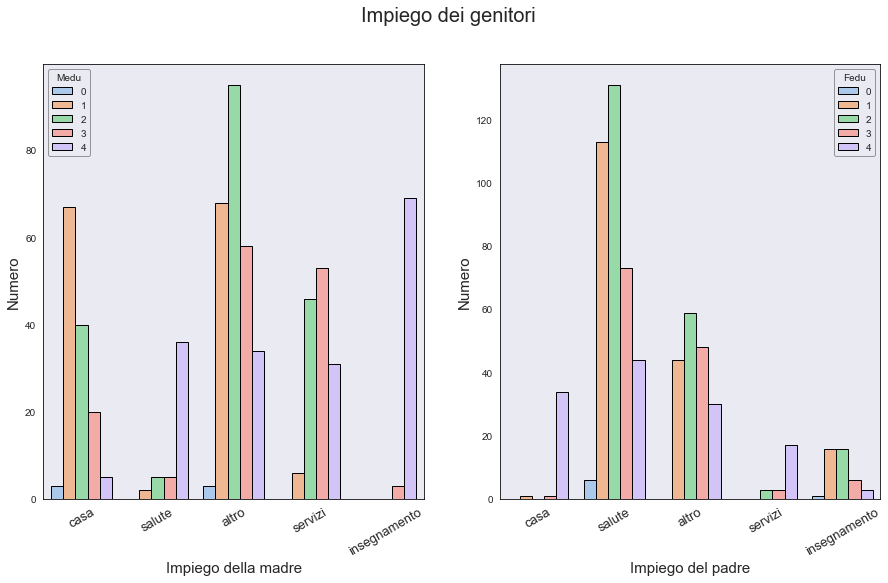

In [16]:
# lavoro della madre e del padre
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# titolo di studio della mamma rispetto al lavoro che svolge
sns.countplot(x = 'Mjob', hue = 'Medu', data = df_por, ax = ax[0])

# titolo di studio del papà rispetto al lavoro che svolge
sns.countplot(x = 'Fjob', hue = 'Fedu', data = df_por, ax = ax[1])

# titolo figura
fig.suptitle('Impiego dei genitori', size = 20)

# titolo asse y
ax[0].set_ylabel('Numero')

ax[1].set_ylabel('Numero')

#titolo asse x 
ax[0].set_xlabel('Impiego della madre')

ax[1].set_xlabel('Impiego del padre')

# posizione etichette
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_xticklabels(['casa', 'salute', 'altro', 'servizi', 'insegnamento'], rotation = 30)

ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels(['casa', 'salute', 'altro', 'servizi', 'insegnamento'], rotation = 30)

plt.show()

Dal grafico emerge come tra le donne, le più istruite lavorino nel campo dell'insegnamento e della salute, mentre non si evidenzia questa correlazione per gli uomini. Inoltre emerge come siano superiori il numero di madri che fanno le casalinghe rispetto a quello dei papà: ciò comporta che siano maggiormente le donne a trascorrere più tempo con i figli.

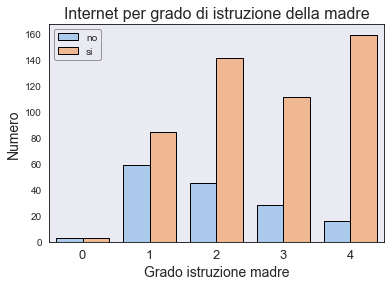

In [18]:
# disponibilità di internet per livello di istruzione della madre
sns.countplot(hue = 'internet', x = 'Medu', data = df_por )

# titolo grafico
plt.title('Internet per grado di istruzione della madre', size = 16)

# cambio etichette legenda
plt.legend(labels = ['no', 'si'])

# titolo asse x
plt.xlabel('Grado istruzione madre', size = 14)

# titolo asse y
plt.ylabel('Numero', size = 14)

plt.show()

Risulta un fatto interessante: sembra che la quota di studenti che hanno internet a disposizione sia direttamente proporzionale al grado di istruzione della madre. 

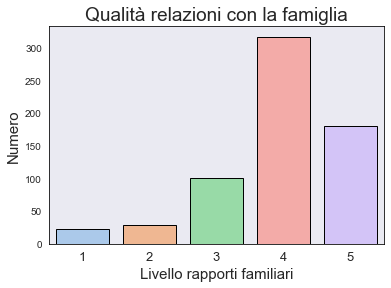

In [20]:
# qualità rapporti con la famiglia
sns.countplot(x = 'famrel', data = df_por)

# titolo del grafico
plt.title('Qualità relazioni con la famiglia')

# titolo asse x
plt.xlabel('Livello rapporti familiari')

# titolo asse y
plt.ylabel('Numero')

plt.show()

Nella scala di valori 1 indica un pessimo rapporto con la famiglia, 5 uno ottimo. Si può notare come la maggior parte degli studenti abbia buoni rapporti con la famiglia (famrel >= 4), ma la quota di studenti che non hanno buone relazioni familiari (famrel <= 2) non è trascurabile: ciò può influire sia sul rendimento (valutazione finale) sia sullo sviluppo di cattive abitudini (maggior consumo di alcolici).

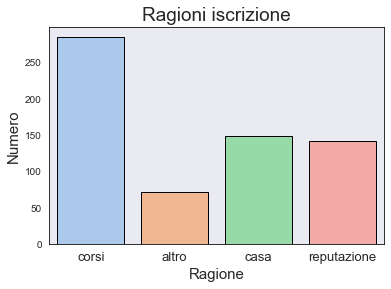

In [22]:
# ragioni per cui gli studenti si sono iscritti
sns.countplot(x = 'reason', data = df_por)

# titolo grafico
plt.title('Ragioni iscrizione')

# titolo asse x
plt.xlabel('Ragione')

# titolo asse y
plt.ylabel('Numero')

# etichette asse x
plt.xticks(ticks = [0, 1, 2, 3], labels = ['corsi', 'altro', 'casa', 'reputazione'])

plt.show()

La maggioranza degli studenti frequenta la scuola che ha scelto per i corsi offerti. Altre motivazioni rilevanti riguardano la vicinanza a casa e la reputazione dell'istituto.

### Rendimento e assenze <a id = 'rendimento_assenze'></a>

C:\Users\Edoardo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Edoardo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


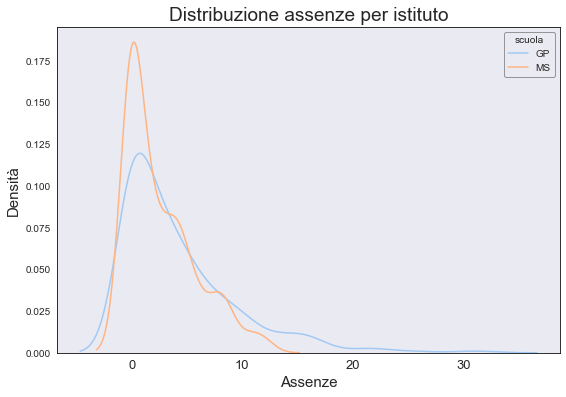

In [23]:
# ingrandisco la figura
plt.figure(figsize = (9,6))

# distribuzione delle assenze scuola Gabriel Pereira
sns.distplot(a = df_por[df_por.school == 'GP'].absences, hist = False, label = 'GP')

# distribuzione delle assenze scuola Mousinho de Silveira
sns.distplot(a = df_por[df_por.school == 'MS'].absences, hist = False, label = 'MS')

# aggiungo una legenda
plt.legend(title = 'scuola', labels = ['GP','MS'])

# titolo grafico
plt.title('Distribuzione assenze per istituto')

# titolo asse x 
plt.xlabel('Assenze')

# titolo asse y
plt.ylabel('Densità')

plt.show()

filterwarnings('ignore')

E' interessante notare che ci sia una differenza nella distribuzione delle assenze rispetto alla scuola che gli studenti frequentano: quelli della Gabriel Pereira tendono ad avere più assenze rispetto ai colleghi della Mousinho de Silveira. 

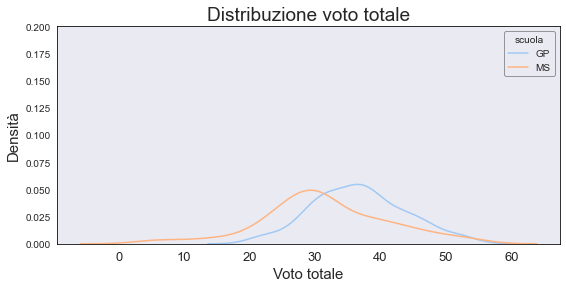

In [25]:
# ingrandisco la figura
plt.figure(figsize = (9,4))

# somma totale dei voti
df_por['total_grade'] = df_por.G1 + df_por.G2 + df_por.G3

# distribuzione del voto totale per Gabriel Pereira
sns.distplot(a = df_por[df_por.school == 'GP'].total_grade, hist = False, label = 'GP')

# distribuzione del voto totale per Mousinho da Silveira
sns.distplot(a = df_por[df_por.school == 'MS'].total_grade, hist = False, label = 'MS')

# aggiungo una legenda
plt.legend(title = 'scuola')

# titolo grafico
plt.title('Distribuzione voto totale')

# titolo asse x
plt.xlabel('Voto totale')

# titolo asse y
plt.ylabel('Densità')

# modifico valori su asse y
plt.ylim(0, 0.2)

plt.show()

filterwarnings('ignore')

Nel grafico sovrastante il voto totale indica la somma dei voti riportati negli esami sostenuti dagli studenti durante l'anno (G1 + G2 + G3).
Si può notare come la distribuzione dei voti della Gabriel Pereira sia traslata a destra rispetto a quella della Mousinho da Silveira: questo è indice di un miglior rendimento degli studenti (o di un diverso metro di giudizio dei docenti) del primo istituto rispetto al secondo.

### Conusmo di alcolici <a id = alcol></a> 

In [27]:
# trasformo il consumo di alcolici in una variabile binaria
df_por['dalc_bin'] = ['LT3' if level < 3 else 
                     'GE3' for level in df_por.Dalc]
df_por['walc_bin'] = ['LT3' if level < 3 else 
                     'GE3' for level in df_por.Walc]

# stampo i valori e le loro frequenze
print(df_por.dalc_bin.value_counts())
print(df_por.walc_bin.value_counts())

LT3    572
GE3     77
Name: dalc_bin, dtype: int64
LT3    397
GE3    252
Name: walc_bin, dtype: int64


Si può notare come bere alcol nel weekend sia molto più consueto rispetto al consumo durante la settimana.

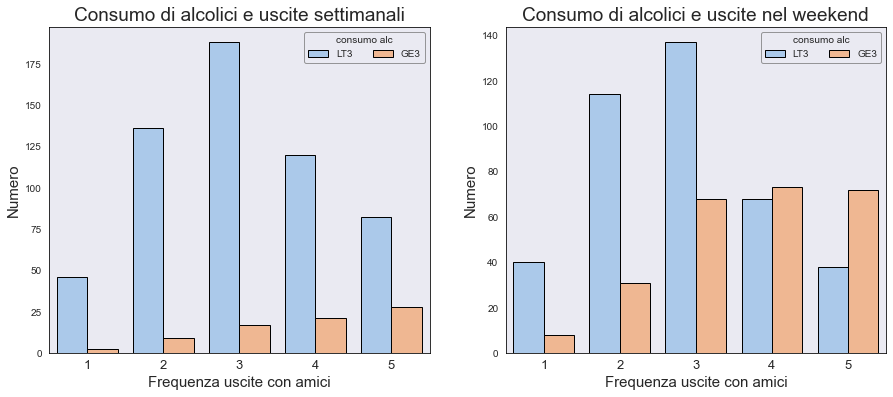

In [28]:
# consumo di alcolici e uscite con amici

# modifico la grandezza della figura
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# consumo di alcolici in base a quanto gli studenti escono con gli amici
sns.countplot(x = 'goout', hue = 'dalc_bin', data = df_por, ax = ax[0])
sns.countplot(x = 'goout', hue = 'walc_bin', data = df_por, ax = ax[1])

# titolo del grafico
ax[0].set_title('Consumo di alcolici e uscite settimanali')
ax[1].set_title('Consumo di alcolici e uscite nel weekend')

# titolo asse x
ax[0].set_xlabel('Frequenza uscite con amici')
ax[1].set_xlabel('Frequenza uscite con amici')

# titolo asse y
ax[0].set_ylabel('Numero')
ax[1].set_ylabel('Numero')

# titolo legenda
ax[0].legend(title = 'consumo alc', ncol = 2)
ax[1].legend(title = 'consumo alc', ncol = 2)

plt.show()

E' evidente che il consumo di alcolici settimanale aumenti al crescere di quanto gli studenti dichiarino di uscire con gli amici. Anche nel consumo di alcol nel weekend esiste questa correlazione: superata una certa frequenza di uscite, il numero di coloro bevono molto (3 o più) rimane abbastanza stabile, ma quello di chi beve poco (LT3) diminuisce. Queste misure tuttavia sono fornite dagli stessi studenti, e quindi possono variare molto in base alla diversa percezione di cosa significhi per ognuno di loro bere o uscire molto.

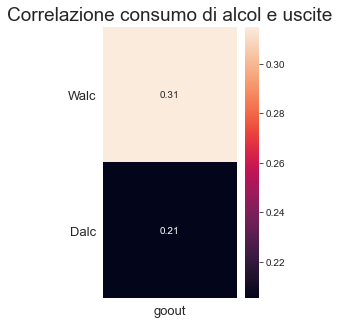

In [30]:
# creo una tabella con le correlazioni
correlations = df_por.corr(method = 'kendall').loc[['Walc','Dalc'],['goout']]

# creo una figura
plt.figure(figsize = (3, 5))

# creo una heatmap con le correlazioni
sns.heatmap(correlations, annot = True, cbar = True, fmt = '.2f')

# titolo del grafico
plt.title('Correlazione consumo di alcol e uscite')

# modifico xticks e yticks
plt.yticks(rotation = 0, size = 13)
plt.xticks(size = 13)

plt.show()

Da questa heatmap risulta che il fenomeno di uscire con gli amici sia maggiormente correlato al consumo di alcol durante il weekend piuttosto che a quello durante la settimana. Tuttavia in entrambi i casi la correlazione non risulta essere particolamente elevata.

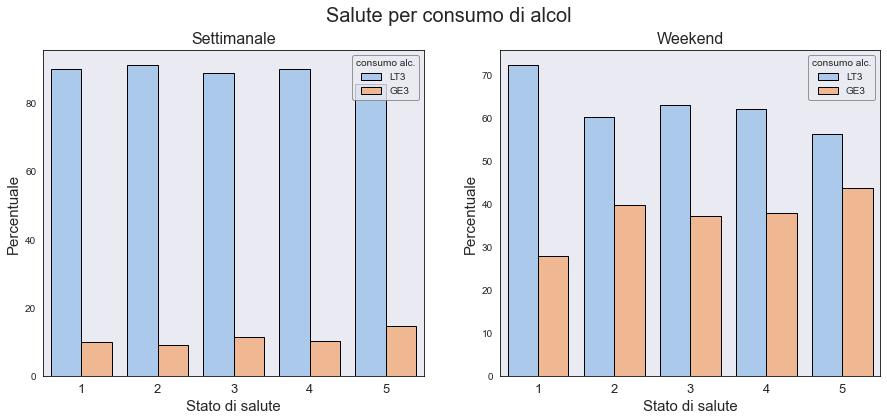

In [32]:
# salute vs. consumo di alcolici

# raggruppo per stato di salute e estraggo il consumo di alcol
health_dalc = df_por.groupby('health')['dalc_bin'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
health_walc = df_por.groupby('health')['walc_bin'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()

# creo la figura
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# salute rispetto al consumo di alcolici
sns.barplot(x = 'health', y = 'percentage', hue = 'dalc_bin', data = health_dalc, ax = ax[0])
sns.barplot(x = 'health', y = 'percentage', hue = 'walc_bin', data = health_walc, ax = ax[1])

# sposto la legenda
ax[0].legend(loc='upper right', title = 'consumo alc.')
ax[1].legend(loc='upper right', title = 'consumo alc.')

# titolo figura
fig.suptitle('Salute per consumo di alcol', size = 20)

# titolo grafico
ax[0].set_title('Settimanale', size = 16)
ax[1].set_title('Weekend', size = 16)

# titolo asse x
ax[0].set_xlabel('Stato di salute')
ax[1].set_xlabel('Stato di salute')

# titolo asse y
ax[0].set_ylabel('Percentuale')
ax[1].set_ylabel('Percentuale')

plt.show()

Non sembra emergere una particolare correlazione tra lo stato di salute e il consumo di alcolici in questo grafico: si può notare come tra gli individui in ottima salute (stato di salute = 5) la quota di coloro che bevono di più sia maggiore (colonna arancione).
Tuttavia bisogna considerare che i valori sullo stato di salute sono stati forniti dagli stessi studenti, pertanto potrebbero non essere veritieri o attendibili. Inoltre le conseguenze di un eccessivo consumo di alcol sono maggiormente visibili a lungo termine. 
Infine è stata operata una semplificazione, raggruppando i dati sul consumo di alcol in due variabili binarie, che pertanto presentano molta eterogeneità al loro interno.

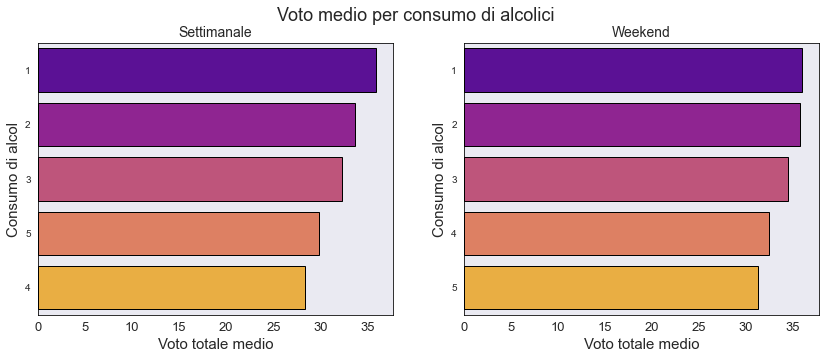

In [33]:
# rendimento medio per consumo di alcolici
mean_vote_for_consumption = df_por.groupby('Dalc').total_grade.mean().sort_values(ascending = False)
mean_vote_for_consumption_we = df_por.groupby('Walc').total_grade.mean().sort_values(ascending = False)

# creo una figura e degli assi
fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

# creo i grafici
sns.barplot(y = mean_vote_for_consumption.index.astype(str), x = mean_vote_for_consumption.values, edgecolor = 'black', palette = 'plasma', saturation = 0.8, ax = ax[0])

sns.barplot(y = mean_vote_for_consumption_we.index.astype(str), x = mean_vote_for_consumption_we.values, edgecolor = 'black', palette = 'plasma', saturation = 0.8, ax = ax[1])

# titolo figura
fig.suptitle('Voto medio per consumo di alcolici', size = 18)

# titoli grafici
ax[0].set_title('Settimanale', size = 14)
ax[1].set_title('Weekend', size = 14)

# definisco variabile sull'asse x
ax[0].set_xlabel('Voto totale medio')
ax[1].set_xlabel('Voto totale medio')

# definisco variabile sull'asse y
ax[0].set_ylabel('Consumo di alcol')
ax[1].set_ylabel('Consumo di alcol')

plt.show()

Il voto medio indica la media della somma dei voti nei tre esami (G1, G2, G3) per ogni gruppo di studenti, divisi sulla base del consumo di alcol. 
Si può notare come al diminuire del consumo settimanale di alcol il rendimento medio degli studenti aumenti: in cima alla classifica tendiamo a trovare quelli che consumano meno alcolici, mentre sul fondo coloro che ne consumano maggiormente. 

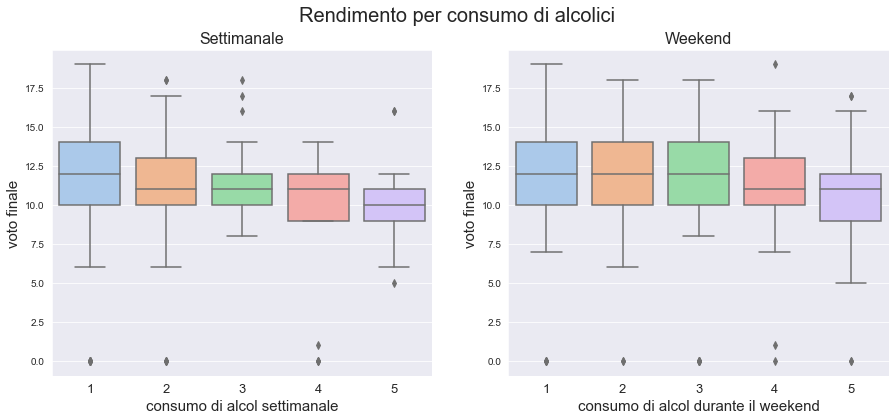

In [35]:
# distribuzione dei voti

# imposto stile
sns.set_style('darkgrid')

# creo una figura
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))

# titolo figura
fig.suptitle('Rendimento per consumo di alcolici', size = 20)

# titolo grafici
ax[0].set_title('Settimanale', size = 16)
ax[1].set_title('Weekend', size = 16)

# creo i grafici
sns.boxplot(x = 'Dalc', y = 'G3', data = df_por, ax = ax[0])
sns.boxplot(x = 'Walc', y = 'G3', data = df_por, ax = ax[1])

# titolo assi x
ax[0].set_xlabel('consumo di alcol settimanale')
ax[1].set_xlabel('consumo di alcol durante il weekend')

# titolo assi y
ax[0].set_ylabel('voto finale')
ax[1].set_ylabel('voto finale')

plt.show()

La media del voto finale (G3) è: 11.91


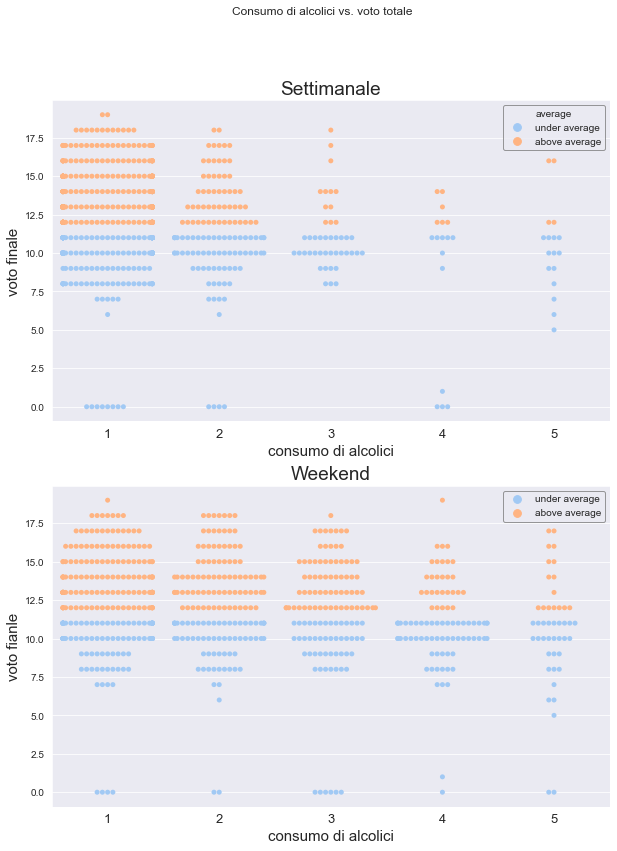

In [36]:
# media della somma totale dei voti
average_grade = df_por.G3.mean()

print(f'La media del voto finale (G3) è: {round(average_grade, 2)}')

# creo colonna 'average'
df_por['average'] = ['above average' if i > average_grade else 'under average' for i in df_por.G3]

# cambio lo stile
sns.set_style(style = 'darkgrid')

# creo la figura e gli assi
fig, ax = plt.subplots(nrows = 2, figsize = (10,13))

# creo swarmplot
sns.swarmplot(x = 'Dalc', y = 'G3', hue = 'average', data = df_por, edgecolor = 'black', ax = ax[0])

sns.swarmplot(x = 'Walc', y = 'G3', hue = 'average', data = df_por, edgecolor = 'black', ax = ax[1])

# cambio posizione legenda
plt.legend(loc='upper right')

# titolo figura
fig.suptitle('Consumo di alcolici vs. voto totale')

# titoli grafici
ax[0].set_title('Settimanale')
ax[1].set_title('Weekend')

# imposto nomi asse x
ax[0].set_xlabel('consumo di alcolici')
ax[1].set_xlabel('consumo di alcolici')

# imposto nomi asse y
ax[0].set_ylabel('voto finale')
ax[1].set_ylabel('voto fianle')


plt.show()

Anche da quest'ultimo grafico risulta evidente come la quota di studenti con un voto totale sopra la media diminuisca all'aumentare del grado di consumo di alcolici. Il fenomeno è ancora più evidente nel consumo di alcol settimanale.

In [37]:
df_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   school       649 non-null    object
 1   sex          649 non-null    object
 2   age          649 non-null    int64 
 3   address      649 non-null    object
 4   famsize      649 non-null    object
 5   Pstatus      649 non-null    object
 6   Medu         649 non-null    int64 
 7   Fedu         649 non-null    int64 
 8   Mjob         649 non-null    object
 9   Fjob         649 non-null    object
 10  reason       649 non-null    object
 11  guardian     649 non-null    object
 12  traveltime   649 non-null    int64 
 13  studytime    649 non-null    int64 
 14  failures     649 non-null    int64 
 15  schoolsup    649 non-null    object
 16  famsup       649 non-null    object
 17  paid         649 non-null    object
 18  activities   649 non-null    object
 19  nursery      649 non-null    

### Variabili più rilevanti <a id = rel_var></a>

Di seguito costruiremo una matrice per stabilire come le varie features risultino correlate fra loro e in particolare il peso di ciascuna di esse sul rendimento scolastico, dato dai voti riportati negli esami (G1, G2 e G3).

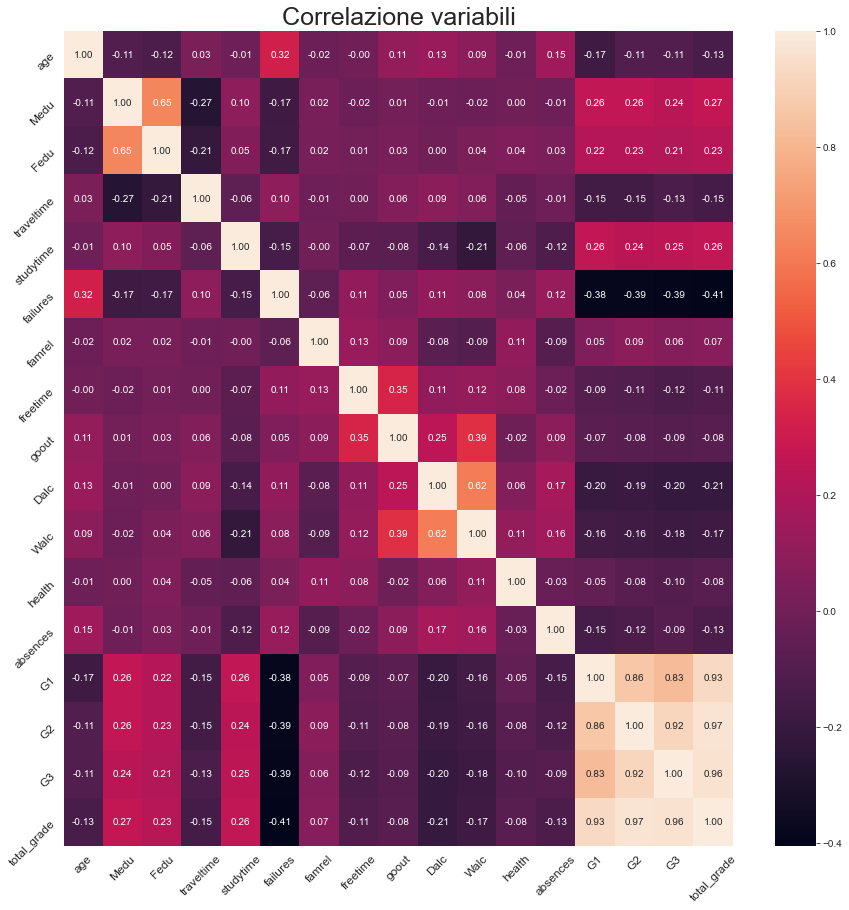

In [38]:
# correlazione tra variabili numeriche

# creo una figura
plt.figure(figsize=(15,15))

# creo una heatmap
sns.heatmap(df_por.corr(), annot = True, cbar = True, fmt='.2f')

# aggiungo titolo
plt.title('Correlazione variabili', size = 25)

# routo ticks sugli assi
plt.yticks(rotation = 45, size = 'large')
plt.xticks(rotation = 45, size = 'large')

plt.show()

Dalla matrice si può notare come le uniche variabili che presentano un elevato valore siano quelle naturalmente correlate, come ad esempio i voti nei vari esami (G1, G2, G3) o il consumo di alcolici nel weekend rispetto a quello totale.
Emerge anche una correlazione abbastanza elevata tra il grado di istruzione dei genitori dei ragazzi.
Come evidenziato nell'analisi esplorativa, esiste una correlazione negativa tra il consumo di alcolici totale degli studenti e i voti che conseguono, ma è piuttosto debole. 
Più elevata risulta essere quella tra il numero di bocciature e lo stesso rendimento degli studenti negli esami.

---

## Data Cleaning <a id = data_cleaning></a>

Lo scopo successivo di questa analisi è quello di addestrare più modelli sul dataset a disposizione (df_por) e stabilire quale sia il migliore nello stimare il voto finale degli studenti (G3).
Per fare ciò separeremo il target della previsione (colonna G3) dal resto del dataset, che costituirà l'insieme delle features utili al modello a predire il voto finale.

Al fine di fornire al modello più informazioni possibili, nel seguito provvederemo ad una fase di data cleaning, per rendere alcune variabili qualitative nominali (come ad esempio il genere degli studenti) interpretabili dal modello.

In [41]:
df_por.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'total_grade',
       'dalc_bin', 'walc_bin', 'average'],
      dtype='object')

In [42]:
# elimino colonne 
df_dropped = df_por.drop(columns = ['G1', 'G2', 'total_grade', 'failures', 'absences', 'dalc_bin', 'walc_bin', 'average'])

Nella cella precedente sono state eliminate le colonne:
* ***G1, G2, total_grade, failures, absences*** perchè fanno riferimento al rendimento o alla condotta degli studenti, e il loro inserimento nel modello non permette di valutare al meglio quali fattori di tipo familiare o sociale influiscano maggiormente sul voto finale;
* ***dalc_bin, walc_bin*** perchè costruite esclusivamente ai fini della EDA;
* ***average*** perchè costruita sulla base di G3, che è il target del modello di predizione.

In [43]:
df_dropped.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'G3'],
      dtype='object')

In [44]:
# mostro tutte le colonne
pd.set_option('display.max_columns', None)

# uso la codifica one-hot per le variabili categoriche nominali
df_one_hot = pd.get_dummies(data = df_dropped, dtype = int)

display(df_one_hot.head())

# nuovo numero di colonne
print(f'Il nuovo dataset ha {len(df_one_hot.columns)} features e {len(df_one_hot)} esempi')


,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,4,3,4,1,1,3,11,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,5,3,3,1,1,3,11,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,4,3,2,2,3,3,12,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,3,2,2,1,1,5,14,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,4,3,2,1,2,5,13,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0


Il nuovo dataset ha 55 features e 649 esempi


### Voto finale uguale a 0 <a id = zero></a>

Nella cella seguente abbiamo evidenziato come siano presenti studenti che hanno ottenuto un voto finale uguale a zero. 

I dati (le features) di questi studenti non sembrano presentare alcuna anomalia. Emerge però un fattore rilevante: **tutti questi studenti fanno parte dello stesso istituto** (*\"Mousinho da Silveira\"*). L'istituto in questione è anche quello che dei due presenta rendimenti scolastici generalmente più bassi, come evidenziato nel corso della EDA.

Un'altra caratteristica che accomuna questi ragazzi è che vengono tutti da nuclei familiari composti da più di tre persone.

Invece che ad un pessimo rendimento, lo zero del target potrebbe essere da imputare all'assenza degli studenti all'esame finale o a qualche fatto che ha portato all'invalidazione della prova.

In [46]:
# estraggo gli studenti con voto finale uguale a zero
zeros = df_one_hot[df_one_hot['G3'] == 0].index

# controllo i loro dati
display(df_one_hot.loc[zeros, : ])

# percentuale studenti con voto 0
zeros_pct = len(zeros)/len(df_one_hot) * 100
print(f'Gli stduenti che hanno registrato zero come voto finale sono il {round(zeros_pct, 2)}%')

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
163,18,1,1,1,1,2,3,5,2,5,4,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1
440,16,1,1,2,2,5,4,5,4,5,3,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1
519,16,2,1,2,2,5,2,1,1,1,2,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0
563,17,2,2,1,1,1,2,1,2,3,5,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1
567,18,3,2,1,1,2,3,1,2,2,5,0,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0
583,18,2,2,2,1,5,5,5,1,1,3,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1
586,17,4,2,1,2,5,5,5,1,3,5,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0
597,18,2,2,3,2,4,3,3,1,1,4,0,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1
603,18,4,2,1,2,5,3,1,1,1,5,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1
605,19,1,1,2,1,5,5,5,2,3,2,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0


Gli stduenti che hanno registrato zero come voto finale sono il 2.31%


Potremmo gestire questi casi in due modi:
* ***eliminare completamente*** gli esempi per cui è stato registrato un voto finale uguale a zero;
* ***assegnare loro il valore medio*** degli altri target dell'analisi (sia per il training che per il test set).

Assegnare il valore medio dei target a questi esempi potrebbe essere rischioso, visto che non sono note le ragioni che hanno portato all'assegnazione di questo voto e attribuire a questi elementi un voto diverso da quello riportato potrebbe fuorviare il modello. A mio avviso non vale la pena procedere in questo senso, soprattutto dal momento che i casi in questione costituiscono esclusivamente il 2.31% del totale, quindi la loro rimozione non costituisce una grande perdita in termini di informazione per i modelli che addestreremo.
Pertanto in seguito procederemo all'eliminazione di questi esempi.

In [47]:
# elimino esempi con voto = a 0
df_one_hot.drop(index = zeros, inplace = True)

Terminate queste operazioni di data cleaning, si può procedere alla separazione delle features dal target della predizione:

In [48]:
# creo la matrice delle features
X = df_one_hot.drop(columns = 'G3')

# creo vettore target
y = df_one_hot.G3

# divido in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Feature scaling <a id = fs></a>

Nel seguito verranno utilizzati dei modelli che necessitano della scalatura dei dati. A questo scopo, e anche al fine di evitare che la eventuale presenza di outliers influenzi i risultati della predizione, faremo uso di un ***Robust Scaler***. 

Il Robust Scaler sottrae ad ogni feature (di ogni esempio) la mediana per quella feature e la divide per l'IQR. In questo modo riesce a gestire meglio gli outliers rispetto agli altri tipi di scalatura dei dati.

In [49]:
# inizializzo lo scaler
scaler = RobustScaler()

# lo addestro e lo applico ai dati di training
scaler.fit_transform(X_train)

# lo applico ai dati di test
scaler.transform(X_test)

array([[ 0. ,  0. ,  0. , ...,  0. , -1. ,  1. ],
       [-0.5,  0.4,  0. , ...,  0. , -1. ,  1. ],
       [ 0. , -0.4, -0.5, ..., -1. ,  0. ,  0. ],
       ...,
       [ 0. , -0.4, -0.5, ...,  0. ,  0. ,  0. ],
       [-1. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0.8,  0.5, ...,  0. ,  0. ,  0. ]])

---

## Modelli di predizione <a id = models></a>

### Decision Tree <a id =dt></a>

In questa analisi partiremo con un modello piuttosto semplice: ***Decision Tree***. A seconda delle performance e degli errori commessi ci muoveremo via via verso modelli più complessi, per mostrarne i benefici in termini di rendimento.  

In [50]:
# inizializzo il modello
tree = DecisionTreeRegressor()

# definisco le distribuzioni da cui estrarre i parametri
depth_distribution = randint(low = 5, high = 25)

split_distribution = uniform(loc = 0, scale = 0.5)

leaf_distribution = uniform(loc = 0.005, scale = 0.05)

# creo un dizionario coi possibili valori dei parametri da validare
params = {'max_depth' : depth_distribution, 'min_samples_split' : split_distribution, 'min_samples_leaf': leaf_distribution, 'random_state' : [22]}

# creo una randomized grid
reg = RandomizedSearchCV(estimator = tree, param_distributions = params, n_iter = 20, n_jobs = -1, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error'], refit = 'neg_mean_absolute_error', cv = 10, random_state = 22)

# addestro il modello
reg.fit(X_train, y_train)

# i migliori valori dei parametri
print(f'I migliori valori dei parametri sono: ')
for iperparam, value in reg.best_params_.items():
    print(f'{iperparam}: {value}')

# valuto il mean absolute error medio della migliore combinazione di parametri
reg_scoreCV = reg.best_score_
print(f"\nIl mean absolute error del miglior modello è {reg_scoreCV}.")
# print(f"Il mean squared error del miglior modello è {reg.cv_results['']})
                                                  
# valuto l'errore commesso sul test set
predictions = reg.predict(X_test)
reg_test_score = mean_absolute_error(y_test, predictions)
print(f"Il MAE sul test set è {reg_test_score}.")

I migliori valori dei parametri sono: 
max_depth: 23
min_samples_leaf: 0.039552067522479806
min_samples_split: 0.11020225831886282
random_state: 22

Il mean absolute error del miglior modello è -1.80287415737095.
Il MAE sul test set è 2.149821512029569.


Gli iperparametri che abbiamo validato sono:

* **max_depth**: il numero di nodi massimo in una decisione, cioè la lunghezza massima del percorso dalla radice ad una foglia;
* **min_samples_split**: il numero minimo di esempi che un nodo deve contenere per poter essere splittato ulteriormente;
* **min_samples_leaf**: il numero minimo di esempi che una foglia può avere;
* **random_state**: fa si che il modello si comporti in modo deterministico.

Per validare gli iperparametri del modello si è fatto ricorso a Randomized Search. I valori degli iperparametri in ogni combinazione sono stati estratti da una specifica distribuzione, precisata all'interno del dizionario "params".

Il numero di combinazioni di iperparametri utilizzato è 20, cioè il valore del parametro di Randomized Search *\"n_iter\"*. Inoltre, a Randomized Search è stato applicato un *\"random state\"*, per fare in modo che le combinazioni di parametri estratte (e i risultati) fossero sempre le stesse, nel caso in cui la cella venga eseguita più volte.

Anche all'interno degli iperparametri di Decision Tree da validare è stato inserito un *\"random state\"*, con un unico possibile valore: ciò permette di selezionare di volta in volta sempre le stesse features per eseguire il *\"miglior split\"* ad ogni nodo. Così facendo, anche addestrando più volte il modello, l'importanza delle varie features rimarrà sempre la stessa. 

Essendo un problema di regressione, come metrica si è scelto di utilizzare il *mean absolute error*, cioè lo scostamento medio assoluto dal valore target.

Il MAE del "miglior modello" si riferisce alla combinazione di parametri che nella cross-validation di Randomized Search ha prodotto l'errore medio assoluto più basso.

Infine abbiamo riportato il MAE sul test set: il valore è vicino a due. Su una scala di voti che va da 0 a 20 non risulta essere particolarmente elevato, anche se ci sono ancora margini di miglioramento.

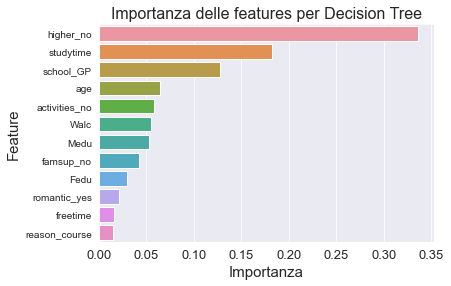

In [51]:
# estraggo le features con importanza maggiore di zero, in ordine decrescente
dt_importances = [imp for imp in np.sort(reg.best_estimator_.feature_importances_) if imp > 0][::-1]

# estraggo gli indici delle features più importanti
features_id = [reg.best_estimator_.feature_importances_.tolist().index(imp) for imp in dt_importances]

# estraggo i nomi delle features più importanti
dt_features = X_train.columns[features_id]

# creo un dataframe con le features più importanti e la loro importanza nel modello
df_importances_dt = pd.DataFrame(zip(dt_features, dt_importances), columns = ['feature', 'importance'])

# creo un grafico
sns.barplot(x = 'importance', y ='feature', data = df_importances_dt)

# imposto i titoli del grafico
plt.title('Importanza delle features per Decision Tree', size = 16)
plt.xlabel('Importanza')
plt.ylabel('Feature')

plt.show()

Dal grafico risulta evidente che le uniche variabili ad avere un'importanza maggiore di zero per il modello sono dodici: gli split ad ogni nodo vengono eseguiti sulla base di una di queste features.

Non sorprende trovare il ***tipo di istituto*** frequentato dagli studenti al terzo posto questa classifica: già durante l'analisi esplorativa si era evidenziato uno scostamento della distribuzione dei voti della *Gabriel Pereira* rispetto alla *Mousinho da Silveira*. Importante notare anche come assuma una certa importanza per il modello il ***consumo di alcol durante il weekend***. I primi due fattori sono invece legati all'intenzione di ***volere proseguire gli studi*** e al ***tempo dedicato allo studio***.

Essendo alcune di queste features ricavate a partire da una variabile binaria attraverso la codifica one hot, anche i loro "opposti" (ad esempio *school_MS* per *school_GP*) rivestono la stessa importanza per il modello. Tuttavia, avendo fissato  *\"random_state\"* anche per Decision Tree (oltre che per Randomized Search), gli split vengono eseguiti sempre sulla base di queste features e non di quelle "opposte".

Dal momento che già di per sè il modello non attribuisce importanza a gran parte delle features, non ritengo necessario procedere all'utilizzo della feature selection.

 ### Mean Squared Error <a id=MSE></a>
 
Il 'miglior modello' di Randomized Search è quello che ha registrato il minor MAE (argomento del parametro 'refit') nella cross-validation eseguita sul training set. Come riportato sotto, si può notare come il 'miglior modello' secondo Randomized Search non sia sempre quello che produce il mean squared error più basso.

In [53]:
# mean squared error

# cambio impostazioni predefinite pandas
pd.set_option('display.max_columns', None)

# carico dizionario di statistiche di Randomized Search CV
validation_data = pd.DataFrame.from_dict(reg.cv_results_)

# mostro le prime righe
validation_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_random_state,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,split5_test_neg_mean_squared_error,split6_test_neg_mean_squared_error,split7_test_neg_mean_squared_error,split8_test_neg_mean_squared_error,split9_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,0.012666,0.005066,0.007481,0.003894,9,0.029084,0.210269,22,"{'max_depth': 9, 'min_samples_leaf': 0.0290840...",-2.062618,-2.068607,-1.820008,-1.545572,-2.106943,-1.900079,-1.818712,-1.618942,-1.752547,-1.721166,-1.841519,0.182987,6,-6.736565,-7.066040,-5.452363,-3.713762,-6.797951,-5.102762,-6.324464,-3.813777,-5.138539,-4.870576,-5.501680,1.143103,6
1,0.010172,0.002742,0.005686,0.001610,16,0.013558,0.169432,22,"{'max_depth': 16, 'min_samples_leaf': 0.013558...",-2.172845,-2.052655,-1.859589,-1.536591,-2.106943,-1.969970,-1.776687,-1.630355,-1.761901,-1.739872,-1.860741,0.199093,9,-6.955560,-6.997995,-5.659430,-3.957106,-6.641957,-5.605697,-6.151227,-3.850977,-5.131475,-4.938629,-5.589005,1.076983,8
2,0.010872,0.002420,0.007180,0.002351,23,0.039552,0.110202,22,"{'max_depth': 23, 'min_samples_leaf': 0.039552...",-2.034189,-2.001966,-1.934956,-1.594211,-2.051303,-1.891218,-1.694013,-1.639262,-1.732833,-1.454791,-1.802874,0.197063,1,-5.740736,-7.447517,-5.932058,-4.264880,-6.737462,-4.994026,-5.901659,-4.264132,-5.041495,-3.915197,-5.423916,1.081801,3
3,0.012665,0.003542,0.005985,0.001410,12,0.012682,0.055655,22,"{'max_depth': 12, 'min_samples_leaf': 0.012682...",-2.204556,-2.148212,-2.195718,-1.662939,-2.296883,-2.045521,-1.975001,-1.808089,-2.072625,-2.017992,-2.042754,0.181855,20,-7.261867,-7.457016,-7.680333,-4.816873,-8.324761,-5.687297,-7.154257,-5.313333,-6.672055,-7.297257,-6.766505,1.072561,20
4,0.010970,0.003308,0.006184,0.002554,13,0.042255,0.094556,22,"{'max_depth': 13, 'min_samples_leaf': 0.042255...",-2.024890,-2.063551,-1.885431,-1.603387,-2.047069,-1.880753,-1.758774,-1.770796,-1.771337,-1.516625,-1.832261,0.175163,4,-5.917113,-7.658343,-5.684377,-4.296609,-6.729942,-5.251836,-6.541162,-4.890524,-5.228800,-4.328399,-5.652710,1.027492,9


In [54]:
# MSE del miglior modello (secondo Randomized Search CV)
mse_best_model = validation_data.loc[reg.best_index_, 'mean_test_neg_mean_squared_error']
print(f'L\'MSE del miglior modello secondo Randomized Search CV è {mse_best_model}.')

# cerco il modello con MSE più basso
best_mse_index = validation_data[validation_data.rank_test_neg_mean_squared_error == 1].index[0]

# valuto se corrisponde al 'miglior modello' di Randomized Search CV
if best_mse_index != reg.best_index_:
    print('Il modello con il MAE più basso non corrisponde a quello con l\'MSE più basso.')
    
    # se non corrisponde, stampo MSE più basso registrato
    best_mse = validation_data.loc[best_mse_index, 'mean_test_neg_mean_squared_error']
    print(f'L\'MSE più basso registrato sul traning set è {best_mse}')
    
else:
    print('Il \'miglior modello\' è anche quello con l\'MSE più basso.')

# stampo MSE del miglior modello sul test set
print(f'L\'MSE del \'miglior modello\' sul test set è {mean_squared_error(y_test, predictions)}.')

L'MSE del miglior modello secondo Randomized Search CV è -5.423916115684821.
Il modello con il MAE più basso non corrisponde a quello con l'MSE più basso.
L'MSE più basso registrato sul traning set è -5.263356156733472
L'MSE del 'miglior modello' sul test set è 7.373967803794505.


Questa disuguaglianza può essere dovuta al fatto che il 'miglior modello', pur essendo quello tendenzialmente più preciso, potrebbe fornire talvolta delle predizioni molto lontane dal loro vero valore, che pesano di più sull'MSE: essendo lo scarto elevato al quadrato, maggiore è l'errore, maggiore è anche il peso che questo errore riveste nel determinare la precisione del modello.

Entrambe le metriche possono essere prese in considerazione per stabilire quale sia la migliore combinazione di parametri, tuttavia nel seguito di questa analisi terremo conto principalmente del MAE per stabilire il modello migliore.

### Linear Regression <a id=lr></a>

Di seguito abbiamo utilizzato la ***Linear Regression*** per stimare il voto finale degli studenti. I parametri utilizzati dal modello sono 55 (uno per ogni feature) e il mean absolute error e l'MSE sul test set sono anche sensibimente inferiori a quelli del *\"best model\"* di Decision Tree. 

In [56]:
# inizializzo la regressione lineare
lin_reg = LinearRegression()

# addestro il modello
lin_reg.fit(X_train, y_train)

# predico il voto finale
lin_preds = lin_reg.predict(X_test)

# calcolo il MAE
lin_test_score = mean_absolute_error(y_test, lin_preds)
print(f'Il MAE sul test set utilizzando la linear regression è: {lin_test_score}.')

# calcolo l'MSE
print(f'L\' MSE sul test set utilizzando la linear regression è: {mean_squared_error(y_test, lin_preds)}.')

print('\n-----------\n')

# stampo i parametri del modello
print(f'I valori dei coefficienti sono: {[round(coef, 3) for coef in lin_reg.coef_]}.')
print(f"Il valore dell'intercetta è {round(lin_reg.intercept_, 3)}.")

Il MAE sul test set utilizzando la linear regression è: 1.9606620429073953.
L' MSE sul test set utilizzando la linear regression è: 6.06626969302824.

-----------

I valori dei coefficienti sono: [0.094, 0.226, -0.002, 0.022, 0.543, 0.269, -0.074, -0.253, -0.235, -0.004, -0.067, 975657299884.11, 975657299883.238, -10077371894700.166, -10077371894700.877, -494365580502.313, -494365580502.544, 957192425927.319, 957192425927.576, -2588911398149.088, -2588911398148.756, 4364180075684.392, 4364180075684.958, 4364180075684.66, 4364180075684.583, 4364180075685.469, -869356739219.499, -869356739220.203, -869356739219.688, -869356739219.963, -869356739218.79, -361883584632.605, -361883584632.061, -361883584632.752, -361883584632.155, -1230864902555.983, -1230864902556.102, -1230864902556.157, 658012408990.672, 658012408989.447, -901160233452.175, -901160233452.809, 5928021414285.231, 5928021414284.319, -5.589, -5.344, -683859353978.494, -683859353978.585, 1378430423107.688, 1378430423110.051, 2

La Linear Regression è un modello molto semplice per il quale non è necessario validare alcun iperparametro. Tuttavia si può notare come tutti i coefficienti siano elevati: ciò potrebbe portare ad una curva di regressione particolarmente complessa e quindi all'overfitting, considerando anche che le features non sono poche (55).

### Ridge Regression <a id=rr></a>

Per fare fronte al rischio di overfitting, di seguito utilizzeremo una versione "regolarizzata" della linear regression, la ***Ridge Regression***.

In [ ]:
"""
bene
"""

In [57]:
# inizializzo la grid search per l'iperparametro della regolarizzazione
ridge_reg = RidgeCV(alphas = np.logspace(start = -5, stop = 4, num = 10, base = 10), cv = 20, scoring = 'neg_mean_absolute_error')
"""
se vuoi confrontare i punteggi di validazione (e non solo quelli di test),
lo dovresti fare usando la stessa divisione in fold del training set
(qui stai facendo un 20fold cross validation)

personalmente, utilizzerei la stessa random search in tutta la pipeline
"""
# addestro il modello
ridge_reg.fit(X_train, y_train)

# miglior valore dell'iperparametro
print(f'Il miglior valore dell\'iperparametro della regolarizzazione è {ridge_reg.alpha_}')

# miglior precisione sul training set
print(f'Il miglior modello ha avuto una precisione di {ridge_reg.best_score_} sul training set')

# predico il voto finale
ridge_preds = ridge_reg.predict(X_test)

# calcolo il MAE
ridge_test_score = mean_absolute_error(y_test, ridge_preds)
print(f'Il MAE sul test set utilizzando la linear regression regolarizzata è: {ridge_test_score}.')

# calcolo l'MSE
print(f'L\' MSE sul test set utilizzando la linear regression regolarizzata è: {mean_squared_error(y_test, ridge_preds)}.')

# stampo i parametri del modello
print('\n--------------\n')
print(f'I valori dei coefficienti sono: {[round(coef, 3) for coef in ridge_reg.coef_]}.')
print(f"Il valore dell'intercetta è {round(ridge_reg.intercept_, 3)}.")

Il miglior valore dell'iperparametro della regolarizzazione è 10.0
Il miglior modello ha avuto una precisione di -1.8201957611477706 sul training set
Il MAE sul test set utilizzando la linear regression regolarizzata è: 1.9353007427968112.
L' MSE sul test set utilizzando la linear regression regolarizzata è: 5.969249517912697.

--------------

I valori dei coefficienti sono: [0.091, 0.251, 0.018, 0.022, 0.53, 0.248, -0.071, -0.248, -0.247, -0.02, -0.068, 0.417, -0.417, 0.318, -0.318, 0.099, -0.099, -0.121, 0.121, -0.16, 0.16, -0.345, 0.083, -0.105, -0.198, 0.566, 0.087, -0.349, -0.028, -0.263, 0.553, -0.202, 0.297, -0.32, 0.225, 0.101, -0.001, -0.1, 0.538, -0.538, 0.303, -0.303, 0.399, -0.399, -0.114, 0.114, 0.036, -0.036, -1.034, 1.034, -0.117, 0.117, 0.157, -0.157].
Il valore dell'intercetta è 7.939.


L'iperparametro che si è validato (*\"alpha\"*) è proprio il parametro di regolarizzazione: più è alto il suo valore, più i coefficienti del modello tenderanno ad essere piccoli (e la curva di regressione ad essere semplice). 

Si può infatti notare come in questo caso i coefficienti siano sensibilmente più bassi della linear regression "non regolarizzata", anche in virtù del fatto che il valore di alpha che ha prodotto le migliori performance nella cross-validation è 100 (un valore uguale a zero indica assenza di regolarizzazione).

Le prestazioni del modello sul test set sono migliori che nel caso precedente: la regolarizzazione consente al modello di essere maggiormente in grado di generalizzare le informazioni apprese durante l'addestramento. Tuttavia, il miglioramento non è particolarmente apprezzabile: l'MSE è più basso di un decimo e il MAE solamente di pochi centesimi rispetto alla versione "non regolarizzata".

Il valore assoluto dei coefficienti fornisce inoltre una misura dell'importanza delle features ad essi associate ai fini della predizione. Possiamo cosi ricavare qual'è il 50% delle features più importante:  

In [58]:
# mediana dei valori assoluti dei coefficienti
abs_median = np.median(np.abs(ridge_reg.coef_))

# creo un filtro per selezionare le migliori features
mask = [True if np.abs(weight) > abs_median else False for weight in ridge_reg.coef_]

# applico la selezione
reg_best_features = df_one_hot.drop(columns = 'G3').columns[mask]

# stampo le features più importanti
print(f'Le features più importanti sono {len(reg_best_features)}:')
print(f'{reg_best_features.to_list()}')

Le features più importanti sono 27:
['Medu', 'studytime', 'famrel', 'goout', 'Dalc', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'Mjob_at_home', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'schoolsup_no', 'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'higher_no', 'higher_yes']


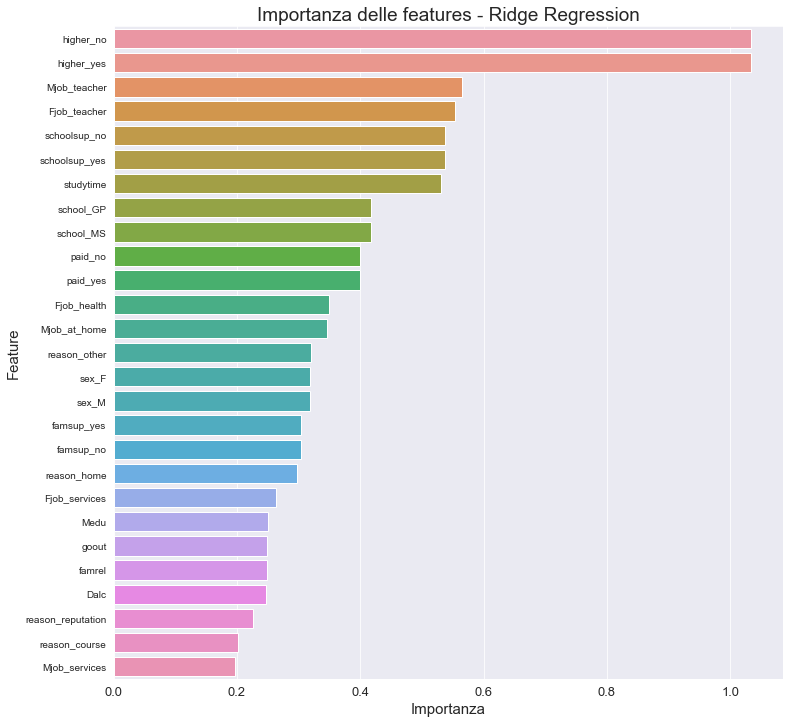

In [59]:
# importanza delle features
features_importance = abs(ridge_reg.coef_[mask])

# creo un dizionario e lo ordino in base all'importanza delle features
most_imp_features = pd.DataFrame(sorted(zip(reg_best_features, features_importance), key = lambda item:item[1], reverse = True), columns = ['feature','importance'])

# imposto grandezza della figura
plt.figure(figsize = (12, 12)) 

# titolo
plt.title('Importanza delle features - Ridge Regression')

# creo un grafico
sns.barplot(y = 'feature', x = 'importance', data = most_imp_features)

# titolo asse x
plt.xlabel('Importanza')

# titolo asse y
plt.ylabel('Feature')

plt.show()

Tra le variabili più importanti, rileva l'intenzione di ***volere proseguire gli studi*** e il fatto che ***uno dei genitori sia un insegnante***. 

Molte coppie di variabili forniscono la stessa informazione (e quindi assumono la stessa importanza), essendo state create attraverso la codifica one-hot a partire dalla stessa feature categorica (ad esempio il ***supporto scolastico*** o la ***possibilità di avere accesso ad internet***).

Non ritengo necessario anche in questo caso operare la feature selection, in quanto la curva di regressione viene già semplificata attraverso la regolarizzazione e l'importanza di ciascuna feature viene già soppesata dal modello mediante l'assegnazione dei coefficienti.

### KNN, Random Forest e Support Vector Machines <a id = knn></a>

Nel seguito di questa sezione utilizzeremo i modelli K-Nearest Neighbors, Random Forest e Support Vector Regressor per stabilire quale di questi fornisca le migliori performance nella cross-validation di Randomized Search e soprattutto sul test set.

* ***K-Nearest Neighbors*** rappresenta il modello più semplice e di più facile interpretazione. Il primo iperparametro validato è *\"n_neighbors\"*, che rappresenta il numero di data points più vicini al nuovo punto, utilizzati per calcolare il target dei nuovi esempi; il secondo iperparametro indica invece l'importanza che assumono questi punti nello stabilire la predizione: se *\"weights\"* è impostato su "distance", al crescere della distanza dei punti dal nuovo esempio, diminuirà la loro influenza sul valore da stimare;


* ***Random Forest*** è un metodo ensemble che utilizza le predizioni di diversi Decision Trees e ne fa la media. L'iperparametro *\"n_estimators\"* rappresenta il numero di Decision Trees presenti nel modello. *\"max features\"* indica invece il numero di features prese in considerazione per scegliere quella su cui eseguire il miglior split ad ogni nodo degli alberi decisionali e *\"random_state\"* fa in modo che le features scelte per eseguire gli split siano sempre le stesse (e quindi siano gli stessi anche i risultati). Infine, *\"max_samples\"* rappresenta la quota di esempi del training set utilizzati per creare dei bootstrap samples sui quali vengono addestrati i vari Decision Trees;


* Per quanto riguarda ***Support Vector Regressor***, si è validato in primo luogo il parametro *\"C\"*: esso è inversamente proporzionale all'intensità della regolarizzazione. La regolarizzazione è un processo atto ad evitare problemi di overfitting: diminuendo il valore di *\"C\"* diminuisce la varianza del modello, ma se il valore dell'iperparametro scende troppo è facile incappare nella problematica opposta (underfitting). L'iperparametro *\"epsilon\"* rappresenta invece l'ampiezza dell'area attorno alla curva di regressione all'interno della quale l'errore sulla predizione non viene considerato. 

In [73]:
# inizializzo i modelli
forest = RandomForestRegressor()
KNN = KNeighborsRegressor()
svr = SVR()

# stabilisco parametri da validare per ogni modello

# parametri random forest
forest_params = {'n_estimators': [100, 200, 500, 750, 1000], 'max_features': randint(low = 1, high = 14), 'max_samples': uniform(loc = 0.1, scale = 0.9), 'random_state' : [42]}

# parametri KNN
KNN_params = {'n_neighbors' : randint(low = 1, high = 20), 'weights': ['uniform','distance']}

# parametri support vector regressor
svr_params = {'C': np.logspace(start = -2, stop = 10, num = 13, base = 10), 'epsilon': np.logspace(start = -3, stop = 3, num = 7, base = 10), 'gamma': np.logspace(start = -9, stop = 3, num = 13, base = 10)}

# associo i modelli ai propri parametri 
parameters_dict = {forest : ['random forest', forest_params], KNN : ['k-nearest neighbors', KNN_params], svr : ['support vector regressor', svr_params]}

# creo lista che conterrà i migliori modelli
best_models = []

# automatizzo la procedura di validazione addestramento con un ciclo for
for model, parameters in parameters_dict.items():
    
    # valido i parametri del modello
    reg = RandomizedSearchCV(estimator = model, param_distributions = parameters[1], n_iter = 20, n_jobs = -1, scoring = ['neg_mean_absolute_error','neg_mean_squared_error'], refit = 'neg_mean_absolute_error', cv = 10, random_state = 42)
    
    # addestro il modello
    reg.fit(X_train, y_train)
    
    # stampo i migliori parametri
    print(f'I migliori parametri di {parameters[0]} sono:')
    for iperparam, value in reg.best_params_.items():
        print(f'{iperparam}: {value}')
    
    # stampo il MAE del modello con la miglior combinazione di parametri
    print(f'\nL\' errore medio assoluto commesso dal miglior modello è: {reg.best_score_}.')
    
    # carico dizionario di statistiche di Randomized Search CV
    validation_data = pd.DataFrame.from_dict(reg.cv_results_)

    # MSE del miglior modello (secondo Randomized Search CV)
    mse_best_model = validation_data.loc[reg.best_index_, 'mean_test_neg_mean_squared_error']
    print(f'L\'MSE del miglior modello {parameters[0]} secondo Randomized Search CV è {mse_best_model}.')

    # cerco il modello con l'MSE più basso
    best_mse_index = validation_data[validation_data.rank_test_neg_mean_squared_error == 1].index[0]

    # valuto se corrisponde al 'miglior modello' di Randomized Search CV
    if best_mse_index != reg.best_index_:
        print('Il modello con il MAE più basso non corrisponde a quello con l\'MSE più basso!')
        
        # stampo l'MSE più basso
        best_mse = validation_data.loc[best_mse_index, 'mean_test_neg_mean_squared_error']
        print(f'Il modello {parameters[0]} con l\'MSE più basso ha prodotto un Mean Squared Error di {best_mse}.')
        
    else:
        print('Il \'miglior modello\' è anche quello con l\'MSE più basso!')
      
    # predico il target del test set
    predictions = reg.predict(X_test)
    
    # stampo il MAE del miglior modello sul test set
    print(f'L\'errore medio assoluto commesso dal miglior modello sul test set è: {mean_absolute_error(y_test, predictions)}.')
    
    # stampo l'MSE del miglior modello sul test set
    print(f'L\'MSE commesso dal miglior modello sul test set è: {mean_squared_error(y_test, predictions)}. \n')
    
    # aggiungo il miglior modello alla lista
    best_models.append(reg.best_estimator_)
    
    # separo le performance dei vari modelli
    if parameters[0] == 'support vector regressor':
        pass
    
    else:
        print('------- \n')
    
# rinomino gli elementi della lista
best_forest = best_models[0]
best_KNN = best_models[1]
best_svr = best_models[2]

I migliori parametri di random forest sono:
max_features: 10
max_samples: 0.3741523922560336
n_estimators: 1000
random_state: 42

L' errore medio assoluto commesso dal miglior modello è: -1.811639671717172.
L'MSE del miglior modello random forest secondo Randomized Search CV è -5.32558342014899.
Il 'miglior modello' è anche quello con l'MSE più basso!
L'errore medio assoluto commesso dal miglior modello sul test set è: 1.860580104712042.
L'MSE commesso dal miglior modello sul test set è: 5.395957159057591. 

------- 

I migliori parametri di k-nearest neighbors sono:
n_neighbors: 15
weights: uniform

L' errore medio assoluto commesso dal miglior modello è: -1.9486767676767678.
L'MSE del miglior modello k-nearest neighbors secondo Randomized Search CV è -6.181489337822671.
Il modello con il MAE più basso non corrisponde a quello con l'MSE più basso!
Il modello k-nearest neighbors con l'MSE più basso ha prodotto un Mean Squared Error di -6.127438092839755.
L'errore medio assoluto commess

Per ognuno dei modelli sono stati stampati:

* La migliore combinazione di valori di iperparametri, cioè quella che ha riportato il MAE più basso all'interno della 10-fold cross-validation di Randomized Search;
* Il valore MAE del miglior modello, nella 10-fold cross-validation;
* Il valore del MSE riportato dal miglior modello durante la 10-fold cross-validation di Randomized Search;
* Se il 'miglior modello' non è quello che ha prodotto l'MSE più basso, il valore dell'MSE più basso registrato nella cross-validation;
* Il MAE del miglior modello sul test set;
* L'MSE del miglior modello sul test set.


Da ciò si evince che il miglior modello in assoluto risulta essere Random Forest. Questo modello è quello che fornisce l'errore (quadratico e assoluto) più basso sia nella cross-validation che sul test set

Nel corso di questa analisi si può notare come tutti i modelli per i quali sono stati validati degli iperparametri presentino un MAE e un MSE negativi durante la cross-validation: ciò è dovuto al fatto che le mertiche utilizzate da Randomized Search sono l'opposto del MAE e dell'MSE, in accordo alla convenzione secondo cui più alto (meno negativo) è il valore della metrica, meglio è.

In termini di prestazioni il beneficio di Random Forest rispetto a SVR non risulta particolarmente significativo: è mediamente più preciso di pochi millesimi nella stima del voto finale. Tuttavia, l'errore quadratico di questi due modelli risulta sensibilmente minore rispetto a KNN: è 6 decimi inferiore per Random Forest e mezzo punto più basso per SVR. KNN è anche tra questi il modello che registra il MAE più alto sul test set.

#### Feature Selection

Dal momento che Random Forest è stato il modello che ha fornito le migliori prestazioni in assoluto, di seguito sono illustrate quali features hanno assunto un maggiore rilievo nella predizione dei valori target per lo stesso modello.

Successivamente, è stata operata la ***feature selection***: i modelli SVR e KNN sono stati riaddestrati su dei dati che contengono solamente le feature più importanti per Random Forest, al fine di verificare se questo potesse portare ad un ulteriore incremento delle prestazioni di questi modelli.

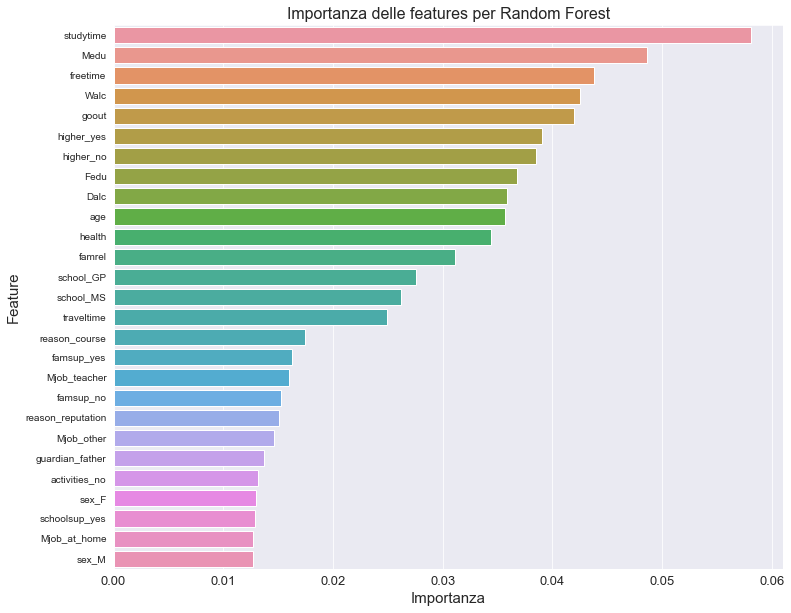

In [70]:
# importanza mediana delle features
median_imp = np.median(best_forest.feature_importances_)

# estraggo il 50% più importante delle features, in ordine decrescente
forest_importances = [imp for imp in np.sort(best_forest.feature_importances_) if imp > median_imp][::-1]

# estraggo gli indici delle features più importanti
features_id = [best_forest.feature_importances_.tolist().index(imp) for imp in forest_importances]

# estraggo i nomi delle features più importanti
forest_features = X_train.columns[features_id]

# creo un dataframe con le features più importanti e la loro importanza nel modello
forest_importances_df = pd.DataFrame(zip(forest_features, forest_importances), columns = ['feature', 'importance'])

# creo una figura
plt.figure(figsize = (12, 10))

# creo un grafico
sns.barplot(x = 'importance', y ='feature', data = forest_importances_df)

# imposto i titoli del grafico
plt.title('Importanza delle features per Random Forest', size = 16)
plt.xlabel('Importanza')
plt.ylabel('Feature')

plt.show()

Come per Decision Tree, anche per Random Forest l'***intenzione di volere proseguire gli studi*** e soprattutto il ***tempo settimanale dedicato allo studio*** sono elementi di primo piano. Tuttavia si può notare come in questo caso l'importanza di queste features sia inferiore in termini assoluti: Random Forest distribuisce l'importanza tra un numero maggiore di features, facendo si che ognuna di queste rilevi meno in termini assoluti.

Tra i fattori di carattere sociale, troviamo altre somiglianze tra i due modelli: il ***grado di istuzione dei genitori*** (in particolare della madre), il ***tempo libero dopo la scuola*** e il ***consumo di alcol durante il weekend*** risultano particolarmente decisivi, anche se Random Forest attribuisce un certo peso anche alle ***relazioni familiari*** e alla ***frequenza con cui i ragazzi escono***.

Lo stesso discorso vale anche per gli elementi di carattere personale, dove oltre all'***età*** e alle ***ragioni alla base della scelta dell'istituto***, random forest prende in esame anche ***la salute*** e il ***tempo del tragitto*** da casa a scuola.

L'attitudine ad utilizzare un maggior numero di features dei modelli più complessi (come in questo caso) può essere legata, oltre che ad una maggiore propensione ad individuare le correlazioni con il target, alla capacità di combinare efficientemente le varie features.

In [96]:
# features prese in considerazione da entrambi i modelli
[feature for feature in forest_features if feature in dt_features]

['studytime',
 'Medu',
 'freetime',
 'Walc',
 'higher_no',
 'Fedu',
 'age',
 'school_GP',
 'reason_course',
 'famsup_no',
 'activities_no']

In [93]:
# creo un selezionatore
selector = SelectFromModel(estimator = best_forest, threshold = 'median', prefit = True)

# trasformo le features del training set
X_train_new = selector.transform(X_train)
print(X_train_new.shape)

# trasformo le features del test set
X_test_new = selector.transform(X_test)

# automatizzo l'addestramento
for model_name, model in {'KNN':best_KNN, 'SVR':best_svr}.items():

    # addestro il modello
    model.fit(X_train_new, y_train)

    # predico il target del test set
    predictions = model.predict(X_test_new)

    # stampo il MAE del miglior modello sul test set
    print(f'L\'errore medio assoluto commesso da {model_name} sul test set è: {mean_absolute_error(y_test, predictions)}.')

    # stampo l'MSE del miglior modello sul test set
    print(f'L\'MSE commesso da {model_name} sul test set è: {mean_squared_error(y_test, predictions)}. \n')

    # separo le performance dei vari modelli
    if model_name == 'KNN':
        print('---------- \n')

    else:
        pass

(443, 27)
L'errore medio assoluto commesso da KNN sul test set è: 1.9598603839441537.
L'MSE commesso da KNN sul test set è: 5.920349040139616. 

---------- 

L'errore medio assoluto commesso da SVR sul test set è: 1.8978261888889891.
L'MSE commesso da SVR sul test set è: 5.729997460153961. 



Si può notare come l'utilizzo della feature selection non abbia portato a grossi miglioramenti in termini di prestazioni dei due modelli: il rendimento di KNN è praticamente il medesimo, mentre quello di SVR sembra addirittura lievemente peggiorato.

#### Analisi dell'errore

Gli esempi per i quali la predizione era più distante dal valore reale non sembrano presentare particolari anomalie. Tuttavia si possono considerare alcuni punti in comune:

1. Quasi tutti gli studenti (tranne uno) hanno come tutore uno dei genitori;
2. ***Nessuno dei genitori*** (né madre né padre) lavora in campo medico;
3. Tutti gli studenti (tranne uno) possiedono genitori conviventi;
4. Nessuno dei ragazzi riceve supporto scolastico ("schoolsup_no")

Tuttavia questi fattori non risultano essere particolarmente considerati da Random Forest:

In [89]:
# predictions di Random Forest
forest_predictions = best_forest.predict(X_test)

# errori assoluti di Random Forest
errors = abs(forest_predictions - y_test).sort_values(ascending = False)

# prendo il 10% più grave degli errori
worst_errors = errors[0:20]

# estraggo gli indici
worst_errors_index = errors[0:20].index

# seleziono gli esempi per i quali ho commesso gli errori maggiori
wrong_predictions = X_test.loc[worst_errors_index,:]

# stampo il risultato
display(wrong_predictions)

,age,Medu,Fedu,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
155,17,2,1,1,1,5,4,5,1,2,5,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0
347,17,4,4,2,3,5,3,4,1,1,5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
596,17,4,2,2,2,4,3,3,1,2,4,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0
239,18,3,1,1,2,5,3,3,1,1,4,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1
185,16,1,0,2,2,4,3,2,1,1,3,1,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
499,16,2,2,1,1,4,2,5,1,2,5,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1
257,17,4,4,1,1,4,2,1,1,2,5,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0
514,16,3,2,1,1,3,1,3,1,4,3,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0
332,18,2,2,1,3,4,3,3,1,2,2,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0
219,17,3,4,1,3,4,4,3,3,4,5,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1


In [109]:
# principali features degli errori
errors_features = ['guardian_other', 'schoolsup_yes', 'Fjob_health', 'Mjob_health', 'PstatusT']

# features considerate dai modelli

# Random Forest
print(f'Features rilevanti per Random Forest: ', [feature for feature in errors_features if feature in forest_features])

# Decision Tree
print(f'Features considerate da Decision Tree: ',[feature for feature in errors_features if feature in dt_features])

# Ridge Regression
print(f'Features rilevanti per la Ridge Regression: ',[feature for feature in errors_features if feature in reg_best_features])

Features rilevanti per Random Forest:  ['schoolsup_yes']
Features considerate da Decision Tree:  []
Features rilevanti per la Ridge Regression:  ['schoolsup_yes', 'Fjob_health']


Non sorprende che, delle 5 features che accomunano gli errori più gravi, solo il fatto di ricevere ***supporto scolastico*** rientra nella metà delle features più importanti per Random Forest, mentre nessuna di queste viene considerata da Decision Tree.

Curioso invece come la Ridge Regression (che pure registra performance leggermente peggiori rispetto a Random Forest) attribuisca invece un certo valore a due delle features in questione: il ***supporto da parte dell'istituto*** e l'***impiego del padre*** sono due fattori cruciali nella stima del voto finale.

---

## Conclusioni <a id = conclusioni></a>

Nel corso dell'analisi sono emersi alcuni aspetti significativi sul contesto (anche exrta-accademico) nel quale crescono gli studenti della classe in questione.

#### Situazione familiare
Abbiamo scoperto che spesso genitori conviventi significano nuclei familiari più larghi, ed un ambiente probabilmente più incoraggiante nel quale poter studiare. E' infatti importante sottolineare che una quota non trascurabile di studenti dichiara di avere cattivi rapporti con i propri familiari.
Appare elevata la correlazione tra il grado di istruzione dei genitori (le coppie tendono ad avere un livello di istruzione simile). Spesso i genitori più istruiti sono entrambi occupati nel campo medico o dell'insegnamento, e questo pregiudica sia il tempo che passano con i figli sia le opportunità che questi hanno: è emblematico come all'aumentare dell'istruzione della madre, cresca la quota di ragazzi con internet a disposizione.  

#### Rendimento e assenze
C’è differenza sia nelle assenze che nel rendimento degli studenti dei due istituti considerati. Va specificato che l'istituto che presenta studenti meno assenti è anche quello che elargisce voti più bassi: la disparità di rendimento potrebbe derivare da un diverso metro di giudizio dei docenti piuttosto che da un minor impegno dei ragazzi.

#### Consumo di alcolici
Più i ragazzi escono con gli amici, più bevono. Tra coloro che dichiarano di essere in ottima salute la quota di chi beve molto (GT3) è tuttavia superiore: ciò potrebbe anche essere legato al fatto che la quantità del consumo di alcolici non è frutto di una precisa misurazione, ma di una stima approssimativa fornita da ogni studente, che potrebbe variare in base alla diversa percezione di ognuno di essi o non essere veritiera.

Il rendimento scolastico (voto medio) sembra invece essere correlato negativamente al consumo di alcolici, specie quello settimanale. Un indicatore abbastanza significativo del voto finale è il numero di failures (bocciature?).

#### Modelli di previsione
Dei modelli presi in esame, Random Forest è quello che presenta le migliori prestazioni: produce il MAE e l'MSE più basso sia nella cross-validation eseguita sul training set, sia sul test set.

E' opportuno sottolineare che le performance di SVR (dopo la scalatura dei dati e l'eliminazione dei target uguali a zero) sono egualmente accurate: il MAE sul test set è solamente qualche millesimo di punto superiore. 

Anche i risultati ottenuti dalla Ridge Regression sono degni di nota: pur richiedendo un tempo di validazione e di addestramento limitato, è risultato un modello capace, *in questo caso*, di registrare delle (relativamente) ottime performance. La regolarizzazione non sembra tuttavia avere inciso particolarmente, essendo il MAE e l'MSE della Ridge solo pochi centesimi inferiori rispetto alla versione "non regolarizzata".

Infine, gettando uno sguardo ai risultati dei vari modelli, è emerso che quelli più complessi tendono a predire meglio i valori di test, nonostante talvolta siano meno precisi sul training set: il MAE di SVR durante la cross-validation è molto superiore a quello di Decision Tree, ma sul test set la situazione è diametralmente opposta. Ciò potrebbe indicare che modelli più complessi sono meno propensi all'overfitting. 